# Cardiac Mechanics Tutorial
This tutorial uses dolfin-x to show how a cardiac mechanics simulation is usually performed. 

Import packages

In [1]:
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import io, fem, nls
import viewer

Read the mesh and boundary information (meshtags)

In [2]:
data_path = 'data/'

# Read mesh
with io.XDMFFile(MPI.COMM_WORLD, data_path + 'mesh.xdmf', "r") as xdmf:
    mesh = xdmf.read_mesh(name='Grid')
    
# Read meshtags (boundary information)
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
with io.XDMFFile(MPI.COMM_WORLD, data_path + 'mt.xdmf', "r") as xdmf:
    meshtags = xdmf.read_meshtags(mesh, name="Grid")

# Define surface normal direction
n0 = ufl.FacetNormal(mesh)

# Define domains and surfaces (integration domains)
ds = ufl.Measure('ds', domain=mesh, subdomain_data=meshtags)
dx = ufl.Measure("dx", domain=mesh)

We can use pyvista to visualize the mesh or meshtags. For simplicity, functions are provided to do this. Plotting in line might be computationally expensive. To disable plotting, just change `viewer.plot_in_line` to `False`.


cannot import name 'vtk' from 'trame.widgets' (/home/jilberto/software/anaconda3/envs/cardiac-mechanics/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(



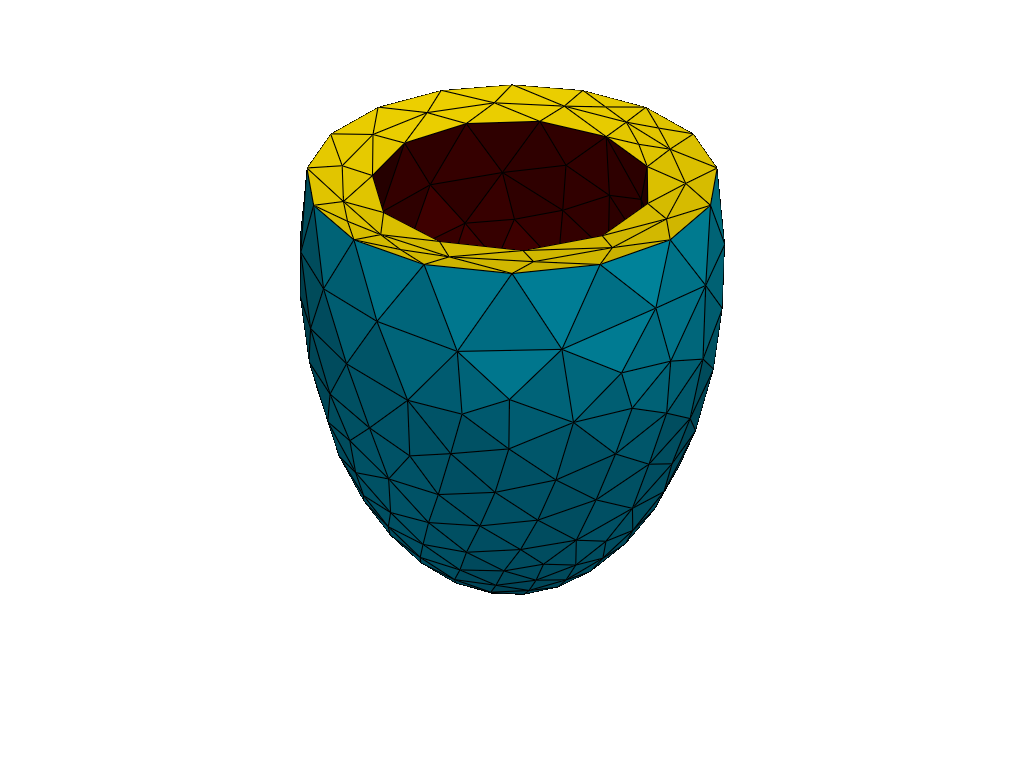

In [3]:
viewer.plot_in_line = True         # ONLY WORKS IN LINUX FOR NOW!!!!
viewer.plot_meshtags(mesh, meshtags)

Define finite element function spaces, test and trial functions (a weird message will appear the first time this cell is run. Do not worry, it is just fenicsx being initialized)

In [4]:
V_u = fem.VectorFunctionSpace(mesh, ('CG', 1))       # space for displacement - continuous quadratic space
V_f = fem.VectorFunctionSpace(mesh, ('CG', 1))       # space for fibers - continuous linear space
du = ufl.TrialFunction(V_u)            # Incremental displacement
var_u = ufl.TestFunction(V_u)             # Test function
u = fem.Function(V_u, name="Displacement")  # Function to store solution

Read fibers

In [5]:
f = fem.Function(V_f)    # In this tutorial fibers are defined in a linear topology
s = fem.Function(V_f)
n = fem.Function(V_f)

f.vector.array = np.loadtxt(data_path + 'fiber.txt').flatten()
s.vector.array = np.loadtxt(data_path + 'sheet.txt').flatten()
n.vector.array = np.loadtxt(data_path + 'sheetnormal.txt').flatten()

Define kinematics

In [6]:
dim = len(u)
I = ufl.variable(ufl.Identity(dim))
F = ufl.variable(I + ufl.grad(u))         # Deformation gradient
C = ufl.variable(F.T*F)                   # Right Green-Cauchy tensor

# Invariants
Ic = ufl.variable(ufl.tr(C))
IIIc = ufl.variable(ufl.det(C))
Ic_bar = ufl.variable(IIIc**(-1./3.) * Ic)

Define material law

In [7]:
mu = fem.Constant(mesh, PETSc.ScalarType(10))
Psi_dev = (mu/2.) * (Ic_bar - 3.)
K = fem.Constant(mesh, PETSc.ScalarType(100))
Psi_vol = (K/2.) * (IIIc - 1.)**2

# Get PK1 stress
P = 2.*ufl.diff(Psi_dev,F) + 2.*ufl.diff(Psi_vol,F)

Define boundary conditions

In [8]:
# Boundary conditions
# Fixed base
u_bc = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
base_dofs = fem.locate_dofs_topological(V_u, meshtags.dim, meshtags.find(2))
bcs = [fem.dirichletbc(u_bc, base_dofs, V_u)]

# Inner pressure
lv_pressure = fem.Constant(mesh, PETSc.ScalarType(1))
T = -lv_pressure*n0

Define residual

In [9]:
# Define residual
F = ufl.inner(ufl.grad(var_u), P)*dx
F += -ufl.inner(var_u, T)*ds(3)

Define problem and solve

In [10]:
problem = fem.petsc.NonlinearProblem(F, u, bcs)
solver = nls.petsc.NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

num_its, converged = solver.solve(u)

We can use pyvista to visualize the solution


cannot import name 'vtk' from 'trame.widgets' (/home/jilberto/software/anaconda3/envs/cardiac-mechanics/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(



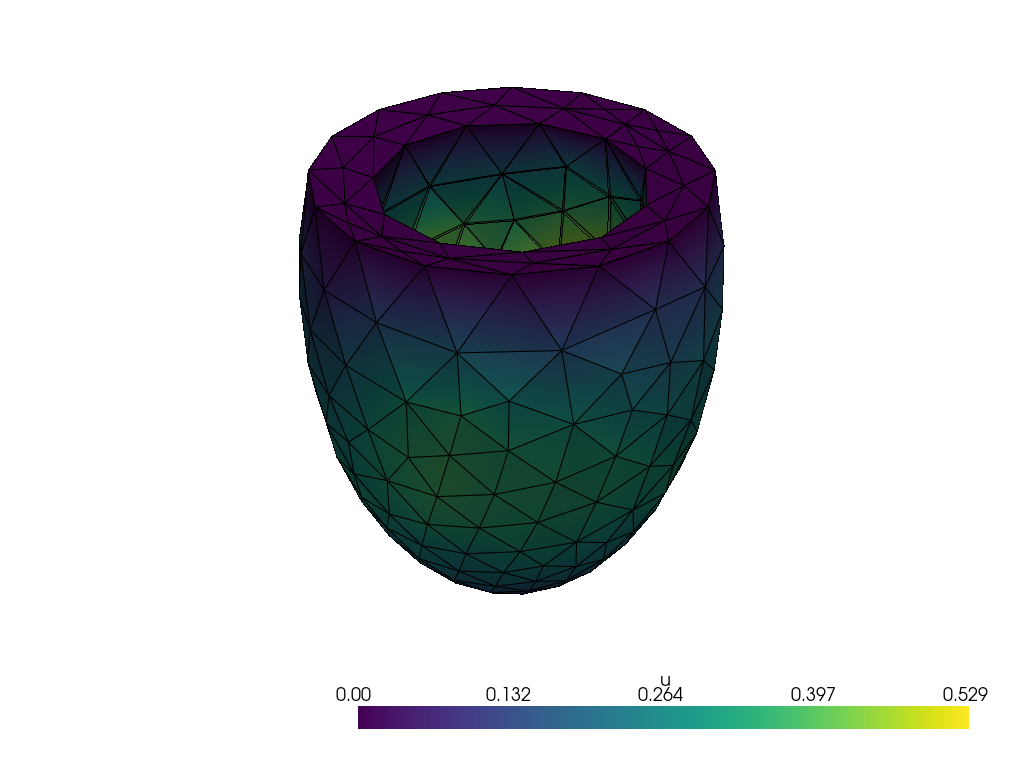

In [11]:
viewer.plot_function(u)

In [12]:
# Clean
f.vector.destroy()
s.vector.destroy()
n.vector.destroy()
u.vector.destroy()